## Import library

In [18]:
import os, sys
sys.path.append("./snn_libs")
from snn_lib.neuron_models.leaky_intergrate_and_fire_model import *
from snn_lib.neuron_models.point_process_model import *
from snn_lib.neuron_models.fixed_spike_train_neuron_model import FixedSpikeTrainNeuronModel

from snn_lib.synapse_models.delay_connection import *
from snn_lib.synapse_models.exponential_synapse import *

from snn_lib.connections.full_connection import *
from snn_lib.connections.possibility_connection import *
from snn_lib.connections.all_to_all_connection import *
from snn_lib.connections.one_to_one_connection import OneToOneConnection
from snn_lib.connections.custom_connection import CustomConnection, CustomOneToOneConnection, CustomAllToAllConnection

from snn_lib.monitors.neuron_monitors import NeuronOutputMonitor, NeuronMembranePotentialMonitor
from snn_lib.monitors.synapse_monitors import *
from snn_lib.monitors.network_recorder_manager import NetworkRecorderManager

from snn_lib.network.network_builder import NetworkBuilder

from snn_lib.plots.snn_recorder_plot import plot_neuron_record
from snn_lib.plots.neuron_plot import plot_possion_neuron_raster

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [19]:
network_builder = NetworkBuilder()

In [20]:
time_steps = 5000 # simulation time steps
freq = 500     # count of sample per second.  
dt = 1 / freq  # time step

## Generate Target and Input Spike Train According a Gaussian Distribution

In [31]:
def generate_1_dim_gaussian_distribution(length, mu, variance, normalize=True):
    mu = length / 2
    variance = length
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, length)
    y = stats.norm.pdf(x, mu, sigma) 
    if normalize:
       y = (y - min(y)) / (max(y) - min(y))
    return y
    

# generate spike rate distribution
target_spike_rates = generate_1_dim_gaussian_distribution(time_steps, time_steps / 2, time_steps / 4, True) * freq

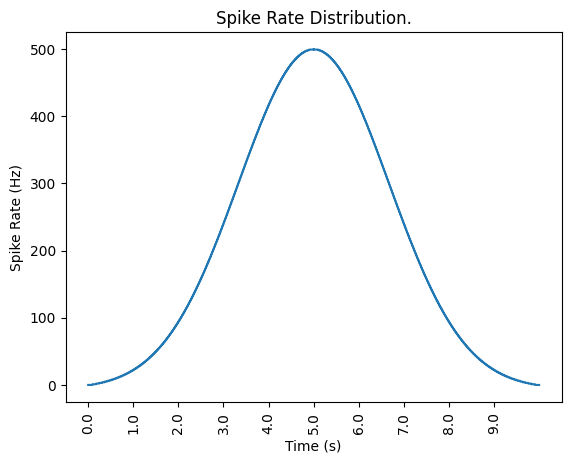

In [32]:
plt.plot(range(0, time_steps), (target_spike_rates).astype(int))
plt.title("Spike Rate Distribution.")
x = np.arange(0, time_steps, freq)
plt.xticks(x, x * dt , rotation='vertical')
plt.xlabel("Time (s)")
plt.ylabel("Spike Rate (Hz)")

plt.show()

In [33]:
target_output_neuron = PointProcessNeuron(N = 1, fr_generator = target_spike_rates.reshape(time_steps, -1), hyperparameters = {'dt': dt, 'simulation_time_duration': time_steps * dt})
target_spikes = target_output_neuron.spikes[:,0]
target_spikes

Num. of spikes: 2056.0
Firing rate: 205.6


array([0., 0., 0., ..., 0., 0., 0.])

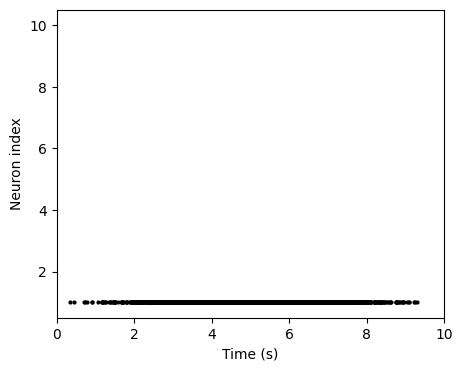

In [34]:
plot_possion_neuron_raster(target_output_neuron)

In [35]:
n_inputs = 4
input_spike_rates = np.zeros((time_steps, n_inputs))
for i in range(n_inputs):
    input_spike_rates[:,i] = generate_1_dim_gaussian_distribution(time_steps, time_steps / 2, time_steps, True) * freq

input_gaussian_neuron = PointProcessNeuron(N = n_inputs, fr_generator = input_spike_rates, hyperparameters = {'dt': dt, 'simulation_time_duration': time_steps * dt})


Num. of spikes: 8191.0
Firing rate: 204.775


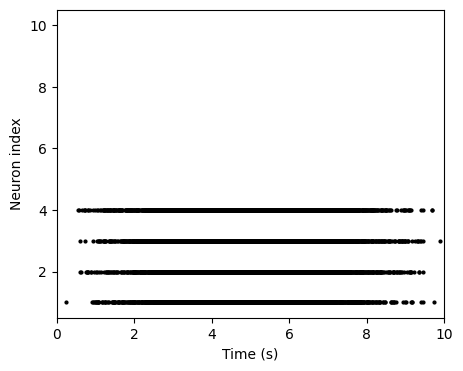

In [36]:
plot_possion_neuron_raster(input_gaussian_neuron)

## Construct Network

In [37]:
n_reservior_neurons = 2000
connection_possibility = 0.2

# --------------------------------------------- neurons ---------------------------------------------
# Generate input neurons
input_neuron = network_builder.add_neuron(f'input', input_gaussian_neuron )

# Generate reservoir neurons
reservoir_neuron = network_builder.add_neuron(f'reservoir', CurrentBasedLIFNeuron(n_reservior_neurons, {'dt': dt}))

# Generate output neurons
output_neuron = network_builder.add_neuron(f'output', CurrentBasedLIFNeuron(1, {'dt': dt}))


# --------------------------------------------- connections ---------------------------------------------
# Connection: reservoir -> reservoir. pre-post neurons are connected with possibility of 0.2, using double exponential synapse.
network_builder.add_connection((f'reservoir', f'reservoir', PossibilityConnection(reservoir_neuron, reservoir_neuron, connection_possibility), \
                                DoubleExponentialSynapse(pre_N = n_reservior_neurons, post_N = n_reservior_neurons, dt = dt, td = 1e-2, tr = 5e-3)))

# Connection: reservoir -> output. Pre-post neurons are connected by all to all connection, using double exponential synapse.
network_builder.add_connection((f'reservoir', f'output', AllToAllConnection(reservoir_neuron, output_neuron), DoubleExponentialSynapse(n_reservior_neurons, 1,  dt = dt, td = 1e-2, tr = 5e-3)))

# Connection: input -> reservoir. Pre-post neurons are connected by possibility connection, using double exponential synapse.
network_builder.add_connection((f'input', f'reservoir', PossibilityConnection(input_neuron, reservoir_neuron, connection_possibility), DoubleExponentialSynapse(n_inputs, n_reservior_neurons, dt = dt, td = 1e-2, tr = 5e-3)))




('input',
 'reservoir',
 <snn_lib.synapse_models.exponential_synapse.DoubleExponentialSynapse at 0x14b043780f40>)

## Build Network

In [38]:
network = network_builder.build_network()
network.initialize_network()

## Build Recorders

In [39]:
train_recorder = NetworkRecorderManager(network.neurons, network.connections)

train_recorder.add_neuron_recorder('neuron_spike_series',  lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron._output_index]])

train_recorder.add_neuron_recorder('neuron_mebrance_potential', lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron.INDEX_V]])


In [40]:
def repeat_vec(vec, repeat_times, axis = 0):
    if axis == 1:
        return np.repeat(vec.transpose()[:,np.newaxis ], repeat_times, axis=1)
    elif axis == 0:
        return  np.repeat(vec[np.newaxis,:], repeat_times, axis=0)

## Functions for applying SuperSpike Algorithm

In [41]:
global error_output_states
global error_reservoir_reservoir_states
global error_input_reservoir_states
global lambda_ij_reservoir_reservoir_states
global lambda_ij_reservoir_output_states
global lambda_ij_input_reservoir_states

td=1e-2
tr=5e-3
b = (td / tr) ** (td / (tr - td))


error_reservoir_reservoir_states = [np.zeros((n_reservior_neurons)), np.zeros((n_reservior_neurons))]
error_output_states = [0, 0]
error_input_reservoir_states = [np.zeros((n_inputs)), np.zeros((n_inputs))]

lambda_ij_reservoir_output_states = [np.zeros((1, n_reservior_neurons)), np.zeros((1, n_reservior_neurons))]
lambda_ij_reservoir_reservoir_states = [np.zeros((n_reservior_neurons, n_reservior_neurons)), np.zeros((n_reservior_neurons, n_reservior_neurons))]
lambda_ij_input_reservoir_states = [np.zeros((n_reservior_neurons, n_inputs)), np.zeros((n_reservior_neurons, n_inputs))]

def surrogate_derivative_fastsigmoid(u, beta=1, vthr=-50):
    return 1 / (1 + np.abs(beta*(u - vthr)))**2
    
def update_error_output(t, target_spikes):
    global error_output_states
    output_spike = train_recorder.get_neuron_recorder('neuron_spike_series')['output'][t]
    r = error_output_states[0]
    hr = error_output_states[1]
    r = r * (1 - dt / tr) + hr / td * dt
    hr = hr * (1 - dt / td) + (target_spikes[t] - output_spike) / b
    error_output_states = [r, hr]

def update_lambda_ij_reservoir_output(t):
    global lambda_ij_reservoir_output_states
    e_output = error_output_states[0]
    r = lambda_ij_reservoir_output_states[0]
    hr = lambda_ij_reservoir_output_states[1]
    r = r * (1 - dt / tr) + hr / td * dt
    cnt_post_neurons = network.neurons['output'].n_neuron
    cnt_pre_neurons = network.neurons['reservoir'].n_neuron

    convolution_target = repeat_vec(surrogate_derivative_fastsigmoid(train_recorder.get_neuron_recorder('neuron_spike_series')['output'][t]), cnt_pre_neurons, axis = 1) * \
                           repeat_vec(train_recorder.get_neuron_recorder('neuron_mebrance_potential')['reservoir'][t], cnt_post_neurons, axis = 0)
    hr = hr * (1 - dt / td) + convolution_target / b
    lambda_ij_reservoir_output_states = [r, hr]

def update_error_reservoir_reservoir(network, t):
    global error_reservoir_reservoir_states
    r1 = error_reservoir_reservoir_states[0]
    r2 = error_output_states[0] * network.connections[1][2].W
    r = r1 + r2
    error_reservoir_reservoir_states = [r]

def update_lambda_ij_reservoir_reservoir(t):
    global lambda_ij_reservoir_reservoir_states
    e_output = error_reservoir_reservoir_states[0]
    r = lambda_ij_reservoir_reservoir_states[0]
    hr = lambda_ij_reservoir_reservoir_states[1]
    r = r * (1 - dt / tr) + hr / td * dt
    
    cnt_post_neurons = network.neurons['reservoir'].n_neuron
    cnt_pre_neurons = network.neurons['reservoir'].n_neuron
    convolution_target = repeat_vec(surrogate_derivative_fastsigmoid(train_recorder.get_neuron_recorder('neuron_spike_series')['reservoir'][t]), cnt_pre_neurons, axis = 1) * \
                            repeat_vec(train_recorder.get_neuron_recorder('neuron_mebrance_potential')['reservoir'][t], cnt_post_neurons, axis = 0)
    hr = hr * (1 - dt / td) + convolution_target / b
    lambda_ij_reservoir_reservoir_states = [r, hr]

def update_error_input_reservoir(network, t):
    global error_input_reservoir_states
    r = error_output_states[0] * network.connections[2][2].W
    error_input_reservoir_states = [r]
    
def update_lambda_ij_input_reservoir(t):
    global lambda_ij_input_reservoir_states
    e_output = error_input_reservoir_states[0]
    r = lambda_ij_input_reservoir_states[0]
    hr = lambda_ij_input_reservoir_states[1]
    r = r * (1 - dt / tr) + hr / td * dt
    cnt_post_neurons = network.neurons['reservoir'].n_neuron
    cnt_pre_neurons = network.neurons['input'].n_neuron
    convolution_target = repeat_vec(surrogate_derivative_fastsigmoid(train_recorder.get_neuron_recorder('neuron_spike_series')['reservoir'][t]), cnt_pre_neurons, axis = 1) * \
                            repeat_vec(train_recorder.get_neuron_recorder('neuron_mebrance_potential')['input'][t], cnt_post_neurons, axis = 0)
    hr = hr * (1 - dt / td) + convolution_target / b
    lambda_ij_input_reservoir_states = [r, hr]


In [42]:
cost_record = []
n_epoches = 100
window_size = 250

In [43]:
for epoch in range(n_epoches):
    cost = 0
    network.initialize_network(True)
    train_recorder.initialize_recorders()
    
    error_reservoir_reservoir_states = [np.zeros((n_reservior_neurons)), np.zeros((n_reservior_neurons))]
    error_output_states = [0, 0]
    error_input_reservoir_states = [np.zeros((n_inputs)), np.zeros((n_inputs))]
    
    lambda_ij_reservoir_output_states = [np.zeros((1, n_reservior_neurons)), np.zeros((1, n_reservior_neurons))]
    lambda_ij_reservoir_reservoir_states = [np.zeros((n_reservior_neurons, n_reservior_neurons)), np.zeros((n_reservior_neurons, n_reservior_neurons))]
    lambda_ij_input_reservoir_states = [np.zeros((n_reservior_neurons, n_inputs)), np.zeros((n_reservior_neurons, n_inputs))]

    # Variables for Adam optimization
    V_1 = np.zeros((1, n_reservior_neurons))
    V_2 = np.zeros((n_reservior_neurons, n_reservior_neurons))
    V_3 = np.zeros((n_reservior_neurons, n_inputs))

    m_1 = 0
    v_1 = 0
    m_2 = 0
    v_2 = 0
    m_3 = 0
    v_3 = 0
    beta_1 = 0.9
    beta_2 = 0.999
    g1 = 0
    g2 = 0
    g3 = 0
    alpha1 = 0.001
    alpha2 = 0.001
    alpha3 = 0.001

    for t in tqdm(range(time_steps)):
            # forward_single_time_step(time, recorder) will evolve all neurons, connections and synapses. And record states to recorder.
            network.forward_single_time_step(t, train_recorder) 

            # -------------------- Batch (size = window_size) Update weights by Adam Algorithm ---------------------------------
            out_v = network.neurons['output']._states[0]
            cost += 0.5 * (target_spikes[t] - out_v) ** 2
            
            ## 1. Update [reservoir - output]
            update_error_output(t, target_spikes)
            update_lambda_ij_reservoir_output(t)
            delta_w_reservoir_output = np.multiply(np.array(error_output_states[0]), lambda_ij_reservoir_output_states[0]) # surrogate gradient
            ## Adam Optimization
            m_1 = beta_1 * m_1 + (1 - beta_1) * delta_w_reservoir_output
            v_1 = beta_2 * v_1 + (1 - beta_2) * (delta_w_reservoir_output ** 2)
            hat_m_1 = m_1 / (1 - beta_1)
            hat_v_1 = v_1 / (1 - beta_2)
            update_w_reservoir_output =  alpha1 * hat_m_1 / (np.sqrt(hat_v_1) + 1e-8)

            g1 += update_w_reservoir_output
            if t % window_size == 0:
                network.connections[1][2].W -= g1.clip(-0.1, 0.1)
                g1 = 0
        
            ## 2. Update [reservoir - reservoir]
            update_error_reservoir_reservoir(network, t)
            update_lambda_ij_reservoir_reservoir(t)
            delta_w_reservoir_reservoir = np.array(error_reservoir_reservoir_states[0]) * lambda_ij_reservoir_reservoir_states[0] # surrogate gradient
            ## Adam Optimization
            m_2 = beta_1 * m_2 + (1 - beta_1) * delta_w_reservoir_reservoir
            v_2 = beta_2 * v_2 + (1 - beta_2) * (delta_w_reservoir_reservoir ** 2)
            hat_m_2 = m_2 / (1 - beta_1)
            hat_v_2 = v_2 / (1 - beta_2)
            update_w_reservoir_reservior =  alpha2 * hat_m_2 / (np.sqrt(hat_v_2) + 1e-8)

            g2 += update_w_reservoir_reservior
            if t % window_size == 0:
                network.connections[0][2].W -= g2.clip(-0.1, 0.1)
                g2 = 0
            
            ## 3. Update [input - reservoir]
            update_error_input_reservoir(network, t)
            update_lambda_ij_input_reservoir(t)
            delta_w_input_reservoir = np.array(error_input_reservoir_states[0]) * lambda_ij_input_reservoir_states[0]
            ## Adam Optimization
            m_3 = beta_1 * m_3 + (1 - beta_1) * delta_w_input_reservoir
            v_3 = beta_2 * v_3 + (1 - beta_2) * (delta_w_input_reservoir ** 2)
            hat_m_3 = m_3 / (1 - beta_1)
            hat_v_3 = v_3 / (1 - beta_2)
            update_w_input_reservoir =  alpha3 * hat_m_3 / (np.sqrt(hat_v_3) + 1e-8)
            g3 += update_w_input_reservoir
            if t % window_size == 0:
                network.connections[2][2].W -= g3.clip(-0.1, 0.1)
                g3 = 0

    print("End of an epoch, cost = %lf" % (cost))
    cost_record.append(cost)

  0%|          | 0/5000 [00:00<?, ?it/s]

 44%|████▍     | 2192/5000 [05:15<14:59,  3.12it/s]

: 

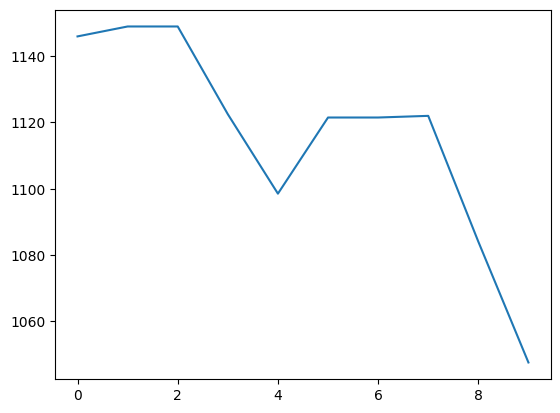

In [ ]:
plt.plot(range(len(cost_record)), cost_record)

In [ ]:
plot_neuron_record(train_recorder, 'neuron_spike_series', lambda record_id, i: 'Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  V_out.', dt = dt)

In [24]:
out_spikes = train_recorder.neuron_recorders['neuron_spike_series'].record['output']